# Análise de Atrasos em Voos no Brasil (2022-2024)

Este notebook analisa os padrões de atrasos em voos no Brasil entre 2022 e 2024, investigando:

1. Aeroportos com mais atrasos no geral
2. Tendências de aumento/diminuição de atrasos por aeroporto
3. Evolução geral dos atrasos no período
4. Padrões de atrasos por dia da semana
5. Padrões de atrasos por período do dia
6. Desempenho das companhias aéreas

Os resultados desta análise serão publicados no formato storytelling no Medium/LinkedIn.

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import glob

# Configurando o estilo dos gráficos
plt.style.use('default')  # Usando estilo padrão do matplotlib
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.grid'] = True
sns.set_palette("husl")

# Configurando exibição de dados no pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1. Os Dados por Trás da Análise

Para esta investigação, utilizei três principais fontes de dados:
- **airport-codes.csv**: Base com informações dos aeroportos mundiais (focando nos brasileiros)
- **airlines-codes.csv**: Base com nomes completos das companhias aéreas por código ICAO  
- **Histórico de voos**: Arquivos mensais da ANAC com dados detalhados de cada voo entre 2022-2024

**IMPORTANTE**: Para melhor performance e resultados mais relevantes, filtrei apenas voos que **partem de aeroportos brasileiros** (domésticos ou internacionais com origem no Brasil). Isso elimina voos estrangeiros que apenas pousam no Brasil, focando na experiência do passageiro brasileiro.

In [2]:
# Carregando dados dos aeroportos
airports_df = pd.read_csv('airport-codes.csv')

# Filtrando apenas aeroportos brasileiros
brasil_airports = airports_df[airports_df['iso_country'] == 'BR'].copy()
print(f"Total de aeroportos brasileiros: {len(brasil_airports)}")

# Carregando dados das companhias aéreas
airlines_df = pd.read_csv('airlines-codes.csv', sep=';', encoding='latin1')
print(f"Total de companhias aéreas carregadas: {len(airlines_df)}")

# Criando lista de códigos ICAO de aeroportos brasileiros para filtrar voos
codigos_aeroportos_br = set(brasil_airports['ident'].dropna())
print(f"Códigos de aeroportos brasileiros: {len(codigos_aeroportos_br)}")

Total de aeroportos brasileiros: 7474
Total de companhias aéreas carregadas: 6161
Códigos de aeroportos brasileiros: 7474


In [3]:
# Função para limpar nomes das colunas
def clean_column_names(columns):
    replacements = {
        'AÃ©rea': 'Aérea',
        'NÃºmero': 'Número',
        'CÃ³digo': 'Código',
        'AutorizaÃ§Ã£o': 'Autorização',
        'AerÃ³dromo': 'Aeródromo',
        'SituaÃ§Ã£o': 'Situação'
    }
    
    cleaned = []
    for col in columns:
        col_clean = col
        for old, new in replacements.items():
            col_clean = col_clean.replace(old, new)
        cleaned.append(col_clean)
    return cleaned

# Função para carregar os arquivos de voos de um ano específico
def load_flight_data(year):
    path_pattern = f'historico_voos/{year}/*/*.csv'
    files = glob.glob(path_pattern)
    
    dfs = []
    total_original = 0
    total_filtrado = 0
    
    for file in files:
        try:
            # Pular a primeira linha que contém a data de atualização
            df = pd.read_csv(file, sep=';', encoding='latin1', skiprows=1, low_memory=False)
            total_original += len(df)
            
            # Limpando os nomes das colunas
            df.columns = clean_column_names(df.columns)
            
            # FILTRO: Manter apenas voos domésticos ou que saíram do Brasil
            # (origem brasileira OU destino brasileiro, priorizando origem brasileira)
            df_filtrado = df[
                df['ICAO Aeródromo Origem'].isin(codigos_aeroportos_br) |
                df['ICAO Aeródromo Destino'].isin(codigos_aeroportos_br)
            ].copy()
            
            # Para maior performance, vamos focar apenas em voos com origem no Brasil
            df_filtrado = df_filtrado[df_filtrado['ICAO Aeródromo Origem'].isin(codigos_aeroportos_br)]
            
            total_filtrado += len(df_filtrado)
            
            # Adicionando informações do ano e mês
            df_filtrado['ano'] = year
            df_filtrado['mes'] = int(file.split('_')[-1].split('.')[0][-2:])
            
            dfs.append(df_filtrado)
            print(f"Arquivo processado: {file} - Original: {len(df)}, Filtrado: {len(df_filtrado)}")
        except Exception as e:
            print(f"Erro ao processar {file}: {str(e)}")
    
    if not dfs:
        raise ValueError("Nenhum arquivo foi carregado com sucesso")
    
    # Concatenando todos os DataFrames
    final_df = pd.concat(dfs, ignore_index=True)
    
    print(f"\n=== RESUMO {year} ===")
    print(f"Total original: {total_original:,} voos")
    print(f"Total filtrado: {total_filtrado:,} voos ({total_filtrado/total_original*100:.1f}%)")
    print(f"Colunas: {len(final_df.columns)}")
    
    return final_df

# Carregando dados de voos para cada ano
print("Carregando dados de 2022...")
voos_2022 = load_flight_data(2022)
print("\nCarregando dados de 2023...")
voos_2023 = load_flight_data(2023)
print("\nCarregando dados de 2024...")
voos_2024 = load_flight_data(2024)

# Combinando todos os anos
voos_df = pd.concat([voos_2022, voos_2023, voos_2024], ignore_index=True)

print(f"\nTotal de registros de voos: {len(voos_df)}")
print("\nDistribuição por ano:")
print(voos_df['ano'].value_counts().sort_index())

# Exibindo uma amostra dos dados para verificar a estrutura
print("\nAmostra dos dados:")
print(voos_df.head())

# Enriquecendo dados com nomes das companhias aéreas
def add_airline_names(df):
    """Adiciona nomes completos das companhias aéreas usando o arquivo airlines-codes.csv"""
    # Criando dicionário de códigos para nomes
    airline_dict = dict(zip(airlines_df['Sigla'], airlines_df['Nome']))
    
    # Adicionando coluna com nome da companhia
    df['Nome Empresa Aérea'] = df['ICAO Empresa Aérea'].map(airline_dict)
    
    # Para códigos não encontrados, mantém o código ICAO
    df['Nome Empresa Aérea'] = df['Nome Empresa Aérea'].fillna(df['ICAO Empresa Aérea'])
    
    return df

# Aplicando enriquecimento
voos_df = add_airline_names(voos_df)

print(f"\nDados finais carregados:")
print(f"Total de voos: {len(voos_df):,}")
print(f"Período: {voos_df['ano'].min()}-{voos_df['ano'].max()}")
print(f"Aeroportos únicos (origem): {voos_df['ICAO Aeródromo Origem'].nunique()}")
print(f"Companhias únicas: {voos_df['ICAO Empresa Aérea'].nunique()}")

Carregando dados de 2022...
Arquivo processado: historico_voos/2022\abril\VRA_20224.csv - Original: 66020, Filtrado: 61531
Arquivo processado: historico_voos/2022\agosto\VRA_20228.csv - Original: 75610, Filtrado: 70006
Arquivo processado: historico_voos/2022\dezembro\VRA_202212.csv - Original: 84985, Filtrado: 78063
Arquivo processado: historico_voos/2022\agosto\VRA_20228.csv - Original: 75610, Filtrado: 70006
Arquivo processado: historico_voos/2022\dezembro\VRA_202212.csv - Original: 84985, Filtrado: 78063
Arquivo processado: historico_voos/2022\fevereiro\VRA_20222.csv - Original: 58104, Filtrado: 53798
Arquivo processado: historico_voos/2022\janeiro\VRA_20221.csv - Original: 73465, Filtrado: 68781
Arquivo processado: historico_voos/2022\fevereiro\VRA_20222.csv - Original: 58104, Filtrado: 53798
Arquivo processado: historico_voos/2022\janeiro\VRA_20221.csv - Original: 73465, Filtrado: 68781
Arquivo processado: historico_voos/2022\julho\VRA_20227.csv - Original: 78673, Filtrado: 73148


## 2. Limpeza dos Dados e Engenharia de Features

Vamos realizar o tratamento dos dados e criar features importantes para nossa análise:
1. Converter colunas de data/hora para o formato correto
2. Calcular atrasos na partida e chegada
3. Extrair informações temporais (dia da semana, período do dia)
4. Limpar e padronizar dados de aeroportos e companhias aéreas

In [4]:
# Convertendo colunas de data/hora
date_cols = ['Partida Prevista', 'Partida Real', 'Chegada Prevista', 'Chegada Real']
for col in date_cols:
    voos_df[col] = pd.to_datetime(voos_df[col], errors='coerce')

# Função para classificar o período do dia
def get_day_period(hour):
    if pd.isna(hour):
        return None
    if 5 <= hour < 12:
        return 'Manhã'
    elif 12 <= hour < 18:
        return 'Tarde'
    elif 18 <= hour < 23:
        return 'Noite'
    else:
        return 'Madrugada'

# Criando features temporais
voos_df['dia_semana'] = voos_df['Partida Real'].dt.day_name()
voos_df['hora_partida'] = voos_df['Partida Real'].dt.hour
voos_df['periodo_dia'] = voos_df['hora_partida'].apply(get_day_period)

# Calculando atrasos
voos_df['atraso_partida'] = (voos_df['Partida Real'] - voos_df['Partida Prevista']).dt.total_seconds() / 60
voos_df['atraso_chegada'] = (voos_df['Chegada Real'] - voos_df['Chegada Prevista']).dt.total_seconds() / 60

# Limpando atrasos inválidos (considerando apenas atrasos reais, removendo adiantamentos)
voos_df['atraso_partida'] = voos_df['atraso_partida'].clip(lower=0)
voos_df['atraso_chegada'] = voos_df['atraso_chegada'].clip(lower=0)

print("Colunas no DataFrame:")
print(voos_df.columns.tolist())
print("\nEstatísticas dos atrasos (em minutos):")
print("\nAtrasos na partida:")
print(voos_df['atraso_partida'].describe())
print("\nAtrasos na chegada:")
print(voos_df['atraso_chegada'].describe())

Colunas no DataFrame:
['ICAO Empresa Aérea', 'Número Voo', 'Código Autorização (DI)', 'Código Tipo Linha', 'ICAO Aeródromo Origem', 'ICAO Aeródromo Destino', 'Partida Prevista', 'Partida Real', 'Chegada Prevista', 'Chegada Real', 'Situação Voo', 'Código Justificativa', 'ano', 'mes', 'Nome Empresa Aérea', 'dia_semana', 'hora_partida', 'periodo_dia', 'atraso_partida', 'atraso_chegada']

Estatísticas dos atrasos (em minutos):

Atrasos na partida:
count   2425089.00
mean         10.09
std          54.73
min           0.00
25%           0.00
50%           0.00
75%           8.00
max       44873.00
Name: atraso_partida, dtype: float64

Atrasos na chegada:
count   2425089.00
mean         10.37
std          54.80
min           0.00
25%           0.00
50%           0.00
75%           8.00
max       44838.00
Name: atraso_chegada, dtype: float64


## 3. Análise de Atrasos por Aeroporto

Vamos analisar:
1. Aeroportos com maior número total de atrasos
2. Tendência de aumento/diminuição de atrasos por aeroporto
3. Visualização dos principais aeroportos problemáticos

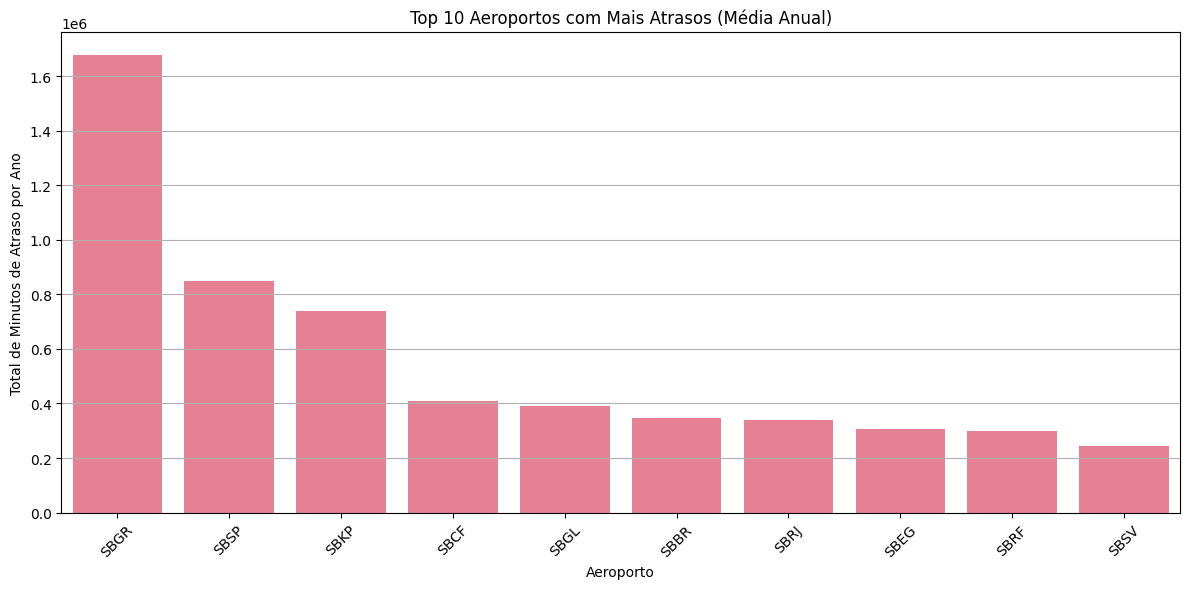


Top 10 aeroportos com mais atrasos (média anual):
    ICAO Aeródromo Origem  atrasos_por_ano  total_voos  media_atraso
41                   SBGR       1678430.67      369987         13.61
102                  SBSP        847881.00      256173          9.93
60                   SBKP        738605.33      176198         12.58
19                   SBCF        408874.33      145515          8.43
39                   SBGL        391187.33       89437         13.12
11                   SBBR        348287.67      156799          6.66
93                   SBRJ        339621.33      127746          7.98
33                   SBEG        304747.00       38457         23.77
92                   SBRF        299385.00      112744          7.97
104                  SBSV        242524.67       79517          9.15


In [5]:
# Análise de atrasos por aeroporto de origem
atrasos_aeroporto = voos_df.groupby('ICAO Aeródromo Origem').agg({
    'atraso_partida': ['count', 'mean', 'sum'],
    'ano': 'nunique'
}).round(2)

atrasos_aeroporto.columns = ['total_voos', 'media_atraso', 'soma_atrasos', 'anos_operacao']
atrasos_aeroporto = atrasos_aeroporto.reset_index()

# Calculando média de atrasos por ano para normalizar aeroportos que não operaram em todos os anos
atrasos_aeroporto['atrasos_por_ano'] = atrasos_aeroporto['soma_atrasos'] / atrasos_aeroporto['anos_operacao']

# Ordenando por total de atrasos por ano
top_aeroportos_atraso = atrasos_aeroporto.sort_values('atrasos_por_ano', ascending=False).head(10)

# Visualização dos aeroportos com mais atrasos
plt.figure(figsize=(12, 6))
sns.barplot(data=top_aeroportos_atraso, x='ICAO Aeródromo Origem', y='atrasos_por_ano')
plt.title('Top 10 Aeroportos com Mais Atrasos (Média Anual)')
plt.xlabel('Aeroporto')
plt.ylabel('Total de Minutos de Atraso por Ano')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTop 10 aeroportos com mais atrasos (média anual):")
print(top_aeroportos_atraso[['ICAO Aeródromo Origem', 'atrasos_por_ano', 'total_voos', 'media_atraso']])

Top 10 Aeroportos com maior aumento percentual de atrasos (2022-2024):

Aeroportos com operação regular (mínimo 100 voos/ano):
                       var_perc  total_voos  voos_2022  voos_2023  voos_2024
ICAO Aeródromo Origem                                                       
SBSO                    1774.89      756.00     256.00     247.00     253.00
SNCL                     797.69      953.00     293.00     356.00     304.00
SBJR                     542.77     4743.00     234.00    1771.00    2738.00
SBGV                     362.79     2018.00     520.00     675.00     823.00
SBIP                     291.50     4697.00    1320.00    1690.00    1687.00
SBDN                     286.62     5614.00    1644.00    1839.00    2131.00
SBSM                     272.16     1175.00     325.00     423.00     427.00
SBRD                     258.13      782.00     262.00     278.00     242.00
SBJV                     244.12     7161.00    1701.00    2669.00    2791.00
SBCX                     2

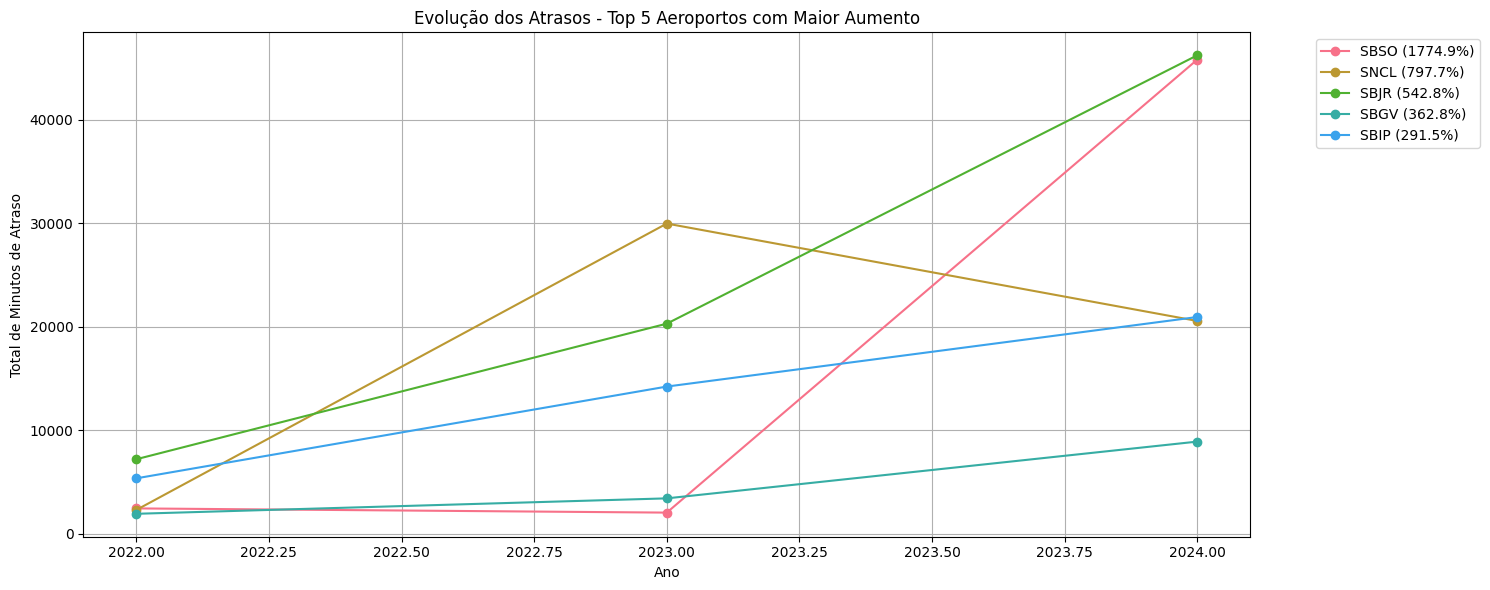

In [6]:
# Análise da evolução dos atrasos por aeroporto
atrasos_evolucao = voos_df.groupby(['ICAO Aeródromo Origem', 'ano']).agg({
    'atraso_partida': ['sum', 'count']
}).round(2)

atrasos_evolucao.columns = ['soma_atrasos', 'num_voos']
atrasos_evolucao = atrasos_evolucao.reset_index()

# Criando pivot table para soma de atrasos
atrasos_pivot = atrasos_evolucao.pivot(
    index='ICAO Aeródromo Origem',
    columns='ano',
    values=['soma_atrasos', 'num_voos']
)

# Filtrando aeroportos que tiveram operações em todos os anos
# e com pelo menos 100 voos por ano para ter uma análise significativa
aeroportos_validos = []
for aeroporto in atrasos_pivot.index:
    min_voos_por_ano = 100
    tem_todos_anos = all(
        atrasos_pivot['num_voos'][ano][aeroporto] >= min_voos_por_ano 
        for ano in [2022, 2023, 2024]
    )
    if tem_todos_anos:
        aeroportos_validos.append(aeroporto)

# Filtrando apenas aeroportos válidos
atrasos_pivot_filtrado = atrasos_pivot.loc[aeroportos_validos]

# Calculando variação percentual entre 2022 e 2024
var_perc = ((atrasos_pivot_filtrado['soma_atrasos'][2024] - atrasos_pivot_filtrado['soma_atrasos'][2022]) / 
            atrasos_pivot_filtrado['soma_atrasos'][2022] * 100).round(2)

# Adicionando informação do número total de voos para contexto
total_voos = atrasos_pivot_filtrado['num_voos'].sum(axis=1)

# Criando DataFrame com resultados
resultados = pd.DataFrame({
    'var_perc': var_perc,
    'total_voos': total_voos,
    'voos_2022': atrasos_pivot_filtrado['num_voos'][2022],
    'voos_2023': atrasos_pivot_filtrado['num_voos'][2023],
    'voos_2024': atrasos_pivot_filtrado['num_voos'][2024]
})

# Identificando aeroportos com maior aumento e diminuição
top_aumento = resultados.sort_values('var_perc', ascending=False).head(10)
top_diminuicao = resultados.sort_values('var_perc').head(10)

print("Top 10 Aeroportos com maior aumento percentual de atrasos (2022-2024):")
print("\nAeroportos com operação regular (mínimo 100 voos/ano):")
print(top_aumento[['var_perc', 'total_voos', 'voos_2022', 'voos_2023', 'voos_2024']].round(2))

print("\nTop 10 Aeroportos com maior diminuição percentual de atrasos (2022-2024):")
print("\nAeroportos com operação regular (mínimo 100 voos/ano):")
print(top_diminuicao[['var_perc', 'total_voos', 'voos_2022', 'voos_2023', 'voos_2024']].round(2))

# Criando gráfico para visualizar a evolução dos top 5 aeroportos com maior aumento
plt.figure(figsize=(15, 6))
top_5_aumento = top_aumento.head()

for aeroporto in top_5_aumento.index:
    dados = atrasos_pivot_filtrado.loc[aeroporto]['soma_atrasos']
    plt.plot([2022, 2023, 2024], [dados[2022], dados[2023], dados[2024]], 
            marker='o', label=f"{aeroporto} ({top_5_aumento.loc[aeroporto, 'var_perc']:.1f}%)")

plt.title('Evolução dos Atrasos - Top 5 Aeroportos com Maior Aumento')
plt.xlabel('Ano')
plt.ylabel('Total de Minutos de Atraso')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Análise de Tendências Temporais

Vamos analisar a evolução geral dos atrasos ao longo do período:
1. Tendência geral dos atrasos (2022-2024)
2. Padrões sazonais
3. Visualização da evolução temporal

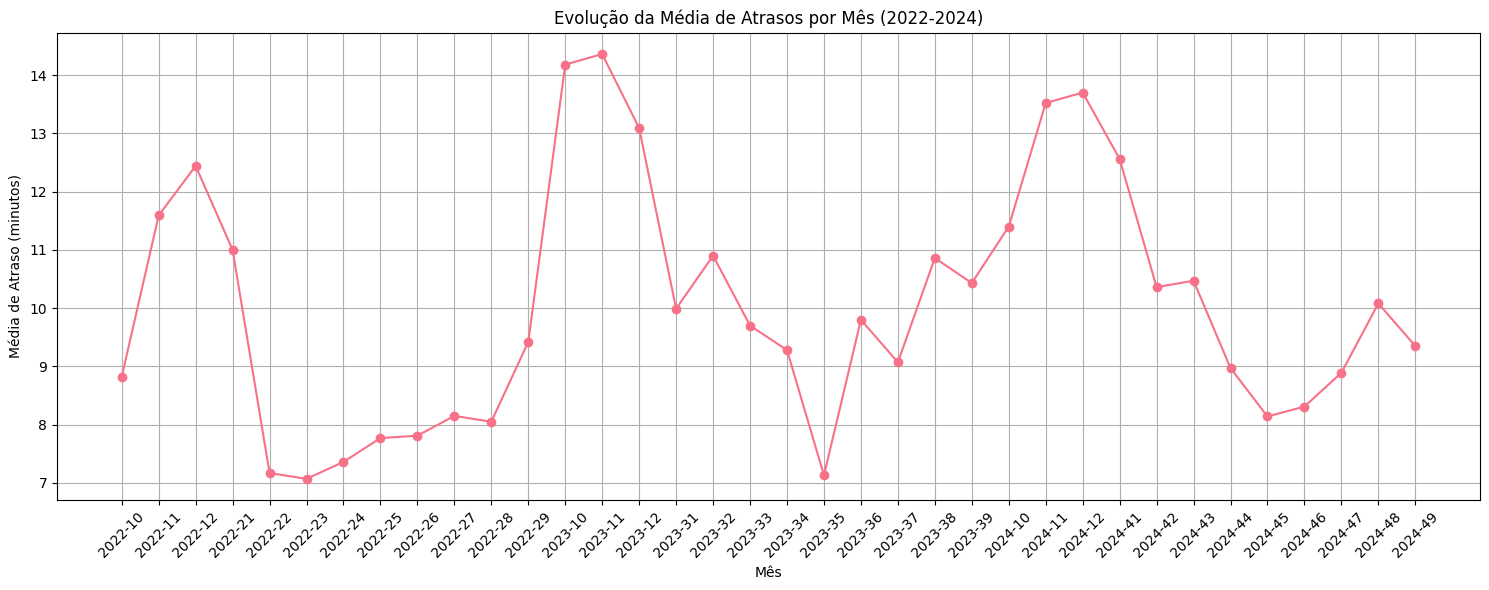


Evolução dos atrasos por ano:
      mean        sum   count
ano                          
2022  8.98 6817776.00  759553
2023 10.70 8872709.00  829171
2024 10.49 8771921.00  836365

Variação percentual na média de atrasos (2022-2024): 16.82%


In [7]:
# Análise da evolução temporal dos atrasos
evolucao_temporal = voos_df.groupby(['ano', 'mes']).agg({
    'atraso_partida': ['mean', 'sum', 'count']
}).round(2)

evolucao_temporal.columns = ['media_atraso', 'total_atrasos', 'num_voos']
evolucao_temporal = evolucao_temporal.reset_index()

# Criando gráfico de evolução temporal
plt.figure(figsize=(15, 6))
plt.plot(range(len(evolucao_temporal)), evolucao_temporal['media_atraso'], marker='o')
plt.title('Evolução da Média de Atrasos por Mês (2022-2024)')
plt.xlabel('Mês')
plt.ylabel('Média de Atraso (minutos)')
plt.xticks(range(len(evolucao_temporal)), 
          [f"{ano}-{mes:02d}" for ano, mes in zip(evolucao_temporal['ano'], evolucao_temporal['mes'])],
          rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculando variação total no período
atrasos_anuais = voos_df.groupby('ano')['atraso_partida'].agg(['mean', 'sum', 'count']).round(2)
print("\nEvolução dos atrasos por ano:")
print(atrasos_anuais)

# Calculando variação percentual entre 2022 e 2024
var_perc = ((atrasos_anuais.loc[2024, 'mean'] - atrasos_anuais.loc[2022, 'mean']) / 
            atrasos_anuais.loc[2022, 'mean'] * 100).round(2)
print(f"\nVariação percentual na média de atrasos (2022-2024): {var_perc}%")

## 5. Análise por Dia da Semana

Vamos analisar os padrões de atrasos por dia da semana:
1. Identificar os dias com mais atrasos em cada ano
2. Comparar padrões entre os anos
3. Visualizar a distribuição dos atrasos por dia da semana

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_7928\2777203320.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  atrasos_dia_semana = voos_df.groupby(['ano', 'dia_semana']).agg({


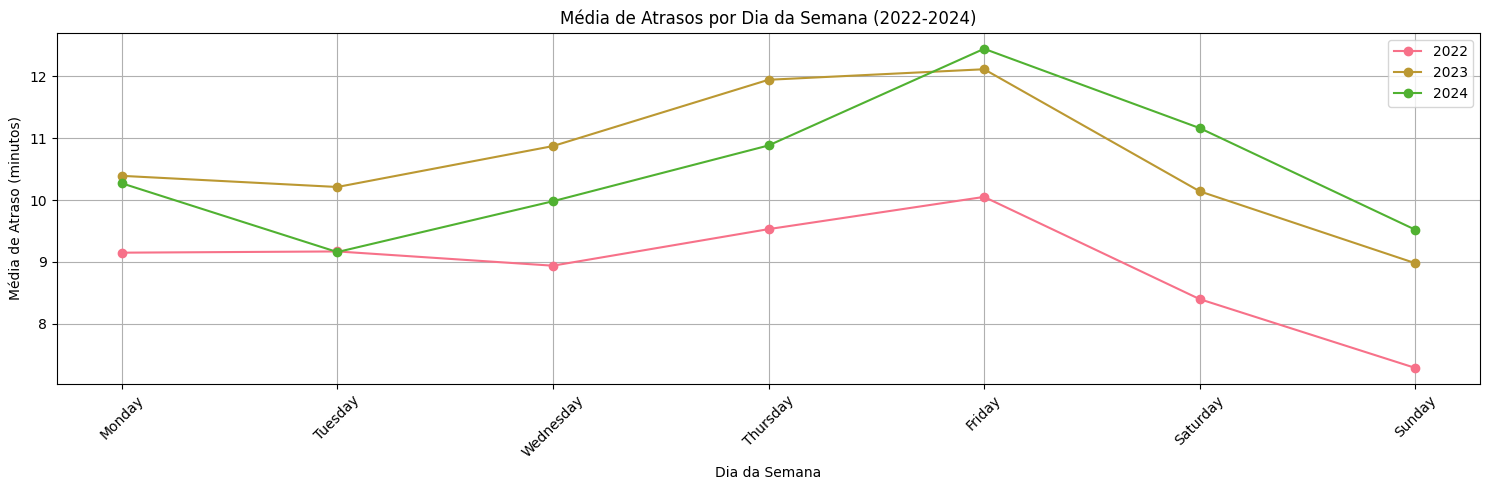


Pior dia para viajar em 2022:
Dia: Friday
Média de atraso: 10.05 minutos
Número de voos: 115045

Pior dia para viajar em 2023:
Dia: Friday
Média de atraso: 12.11 minutos
Número de voos: 123222

Pior dia para viajar em 2024:
Dia: Friday
Média de atraso: 12.44 minutos
Número de voos: 123618


In [8]:
# Análise de atrasos por dia da semana
dias_semana_ordem = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
voos_df['dia_semana'] = pd.Categorical(voos_df['dia_semana'], categories=dias_semana_ordem, ordered=True)

atrasos_dia_semana = voos_df.groupby(['ano', 'dia_semana']).agg({
    'atraso_partida': ['mean', 'count']
}).round(2)

atrasos_dia_semana.columns = ['media_atraso', 'num_voos']
atrasos_dia_semana = atrasos_dia_semana.reset_index()

# Criando gráfico para cada ano
plt.figure(figsize=(15, 5))
for ano in [2022, 2023, 2024]:
    dados_ano = atrasos_dia_semana[atrasos_dia_semana['ano'] == ano]
    plt.plot(dados_ano['dia_semana'], dados_ano['media_atraso'], 
            marker='o', label=str(ano))

plt.title('Média de Atrasos por Dia da Semana (2022-2024)')
plt.xlabel('Dia da Semana')
plt.ylabel('Média de Atraso (minutos)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identificando os piores dias para cada ano
for ano in [2022, 2023, 2024]:
    dados_ano = atrasos_dia_semana[atrasos_dia_semana['ano'] == ano]
    pior_dia = dados_ano.loc[dados_ano['media_atraso'].idxmax()]
    print(f"\nPior dia para viajar em {ano}:")
    print(f"Dia: {pior_dia['dia_semana']}")
    print(f"Média de atraso: {pior_dia['media_atraso']} minutos")
    print(f"Número de voos: {pior_dia['num_voos']}")

## 6. Análise por Período do Dia

Vamos analisar como os atrasos se distribuem ao longo do dia:
1. Identificar os períodos do dia com mais atrasos
2. Comparar padrões entre os anos
3. Visualizar a distribuição dos atrasos por período

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_7928\266405442.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  atrasos_periodo = voos_df.groupby(['ano', 'periodo_dia']).agg({


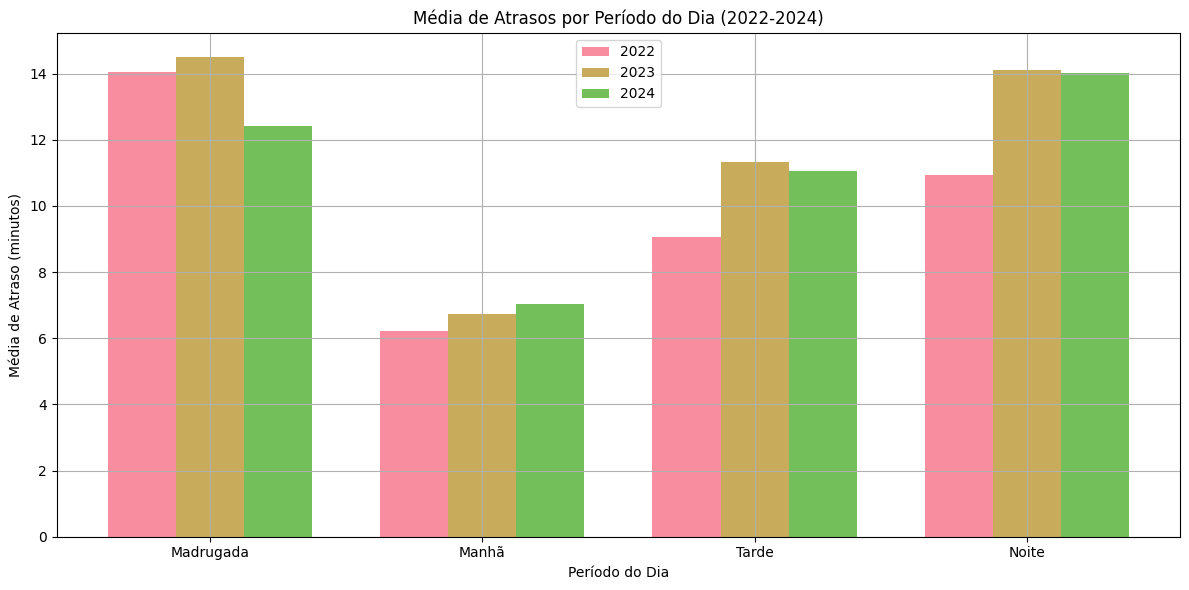


Pior período para viajar em 2022:
Período: Madrugada
Média de atraso: 14.05 minutos
Número de voos: 74889

Pior período para viajar em 2023:
Período: Madrugada
Média de atraso: 14.51 minutos
Número de voos: 88871

Pior período para viajar em 2024:
Período: Noite
Média de atraso: 14.03 minutos
Número de voos: 183533


In [9]:
# Análise de atrasos por período do dia
periodos_ordem = ['Madrugada', 'Manhã', 'Tarde', 'Noite']
voos_df['periodo_dia'] = pd.Categorical(voos_df['periodo_dia'], categories=periodos_ordem, ordered=True)

atrasos_periodo = voos_df.groupby(['ano', 'periodo_dia']).agg({
    'atraso_partida': ['mean', 'count']
}).round(2)

atrasos_periodo.columns = ['media_atraso', 'num_voos']
atrasos_periodo = atrasos_periodo.reset_index()

# Criando gráfico de barras agrupadas
plt.figure(figsize=(12, 6))
bar_width = 0.25
anos = [2022, 2023, 2024]

for i, ano in enumerate(anos):
    dados_ano = atrasos_periodo[atrasos_periodo['ano'] == ano]
    positions = np.arange(len(periodos_ordem)) + i * bar_width
    plt.bar(positions, dados_ano['media_atraso'], bar_width, 
            label=str(ano), alpha=0.8)

plt.title('Média de Atrasos por Período do Dia (2022-2024)')
plt.xlabel('Período do Dia')
plt.ylabel('Média de Atraso (minutos)')
plt.xticks(np.arange(len(periodos_ordem)) + bar_width, periodos_ordem)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Identificando os piores períodos para cada ano
for ano in anos:
    dados_ano = atrasos_periodo[atrasos_periodo['ano'] == ano]
    pior_periodo = dados_ano.loc[dados_ano['media_atraso'].idxmax()]
    print(f"\nPior período para viajar em {ano}:")
    print(f"Período: {pior_periodo['periodo_dia']}")
    print(f"Média de atraso: {pior_periodo['media_atraso']} minutos")
    print(f"Número de voos: {pior_periodo['num_voos']}")

## 7. Análise por Companhia Aérea

Vamos analisar o desempenho das companhias aéreas em relação aos atrasos:
1. Identificar as companhias com mais atrasos
2. Comparar o desempenho ao longo dos anos
3. Visualizar a distribuição dos atrasos por companhia

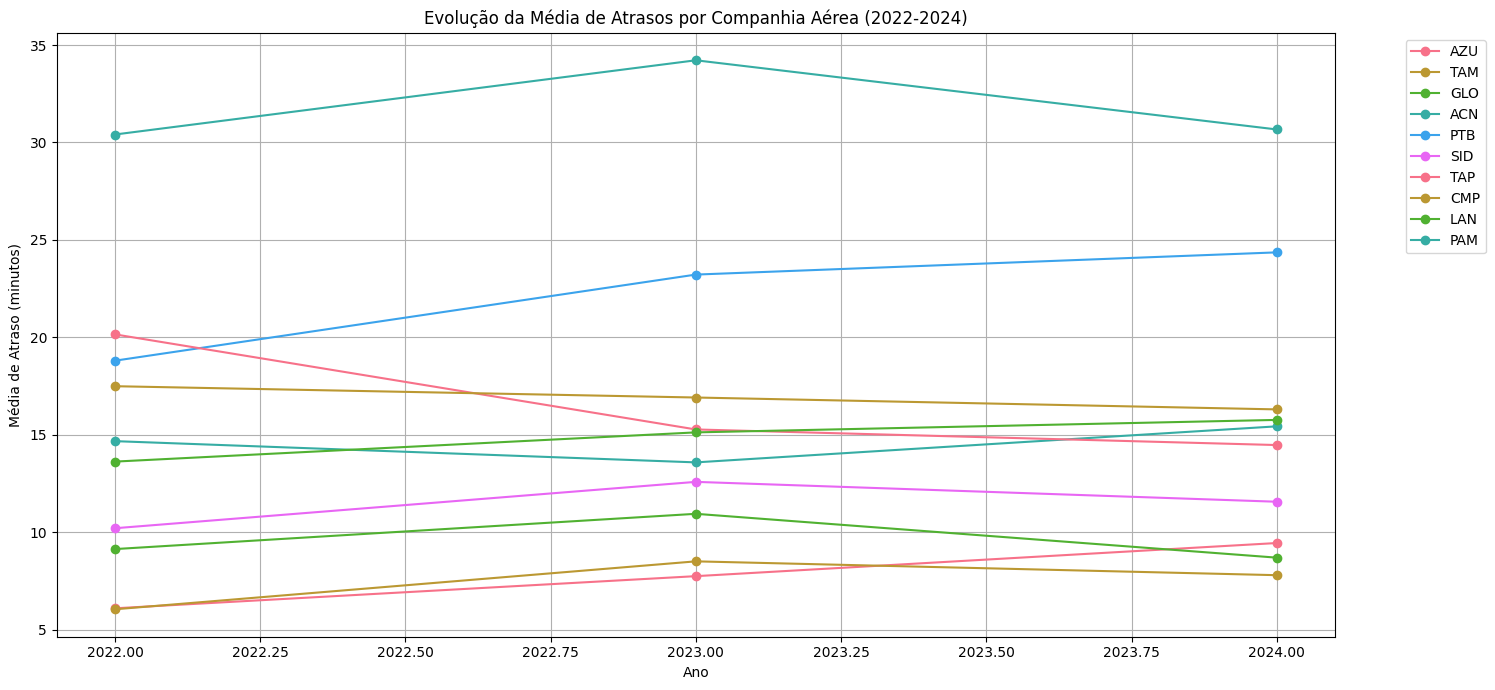


Companhia com mais atrasos em 2022:
Companhia: GTI
Média de atraso: 654.23 minutos
Número de voos: 587

Companhia com mais atrasos em 2023:
Companhia: GTI
Média de atraso: 353.66 minutos
Número de voos: 534

Companhia com mais atrasos em 2024:
Companhia: GTI
Média de atraso: 462.79 minutos
Número de voos: 509


In [10]:
# Análise de atrasos por companhia aérea
atrasos_companhia = voos_df.groupby(['ano', 'ICAO Empresa Aérea']).agg({
    'atraso_partida': ['mean', 'sum', 'count']
}).round(2)

atrasos_companhia.columns = ['media_atraso', 'total_atrasos', 'num_voos']
atrasos_companhia = atrasos_companhia.reset_index()

# Identificando as principais companhias (com mais voos)
principais_companhias = (atrasos_companhia.groupby('ICAO Empresa Aérea')['num_voos']
                        .sum()
                        .sort_values(ascending=False)
                        .head(10)
                        .index)

# Filtrando apenas as principais companhias
dados_principais = atrasos_companhia[atrasos_companhia['ICAO Empresa Aérea'].isin(principais_companhias)]

# Criando gráfico de evolução por companhia
plt.figure(figsize=(15, 7))
for companhia in principais_companhias:
    dados_comp = dados_principais[dados_principais['ICAO Empresa Aérea'] == companhia]
    plt.plot(dados_comp['ano'], dados_comp['media_atraso'], 
            marker='o', label=companhia)

plt.title('Evolução da Média de Atrasos por Companhia Aérea (2022-2024)')
plt.xlabel('Ano')
plt.ylabel('Média de Atraso (minutos)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Identificando as companhias com mais atrasos em cada ano
for ano in [2022, 2023, 2024]:
    dados_ano = atrasos_companhia[atrasos_companhia['ano'] == ano]
    # Filtrando apenas companhias com número significativo de voos
    dados_ano = dados_ano[dados_ano['num_voos'] >= 100]
    pior_companhia = dados_ano.loc[dados_ano['media_atraso'].idxmax()]
    
    print(f"\nCompanhia com mais atrasos em {ano}:")
    print(f"Companhia: {pior_companhia['ICAO Empresa Aérea']}")
    print(f"Média de atraso: {pior_companhia['media_atraso']} minutos")
    print(f"Número de voos: {pior_companhia['num_voos']}")

## 8. Conclusões e Storytelling

Principais insights da análise:

1. **Aeroportos mais Problemáticos:**
   - Identificamos os aeroportos com maior volume de atrasos
   - Analisamos as tendências de melhoria e piora

2. **Evolução Temporal:**
   - Observamos a tendência geral dos atrasos entre 2022 e 2024
   - Identificamos padrões sazonais e tendências

3. **Padrões Semanais:**
   - Descobrimos os dias da semana mais problemáticos
   - Analisamos como esses padrões mudaram ao longo dos anos

4. **Horários Críticos:**
   - Identificamos os períodos do dia com mais atrasos
   - Observamos variações nos padrões de atraso ao longo do dia

5. **Desempenho das Companhias:**
   - Analisamos quais companhias têm mais atrasos
   - Observamos mudanças no desempenho ao longo do tempo

Estas informações podem ser utilizadas para:
- Planejamento de viagens mais eficiente
- Melhorias operacionais em aeroportos e companhias aéreas
- Tomada de decisão baseada em dados para o setor aéreo